# Lidar Processing Workflow
**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes raw lidar point clouds in order to calculate snow depth using PDAL. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

The goal of this project is to process snow depth to the one-meter spatial scale while maintaining conservative under-canopy estimates. Therefore, little interpolation occurs under-canopy. We follow these protocols in order to obtain a 1-m rasterized product (as opposed to the 3-m rasterized product provided by ASO on the NSIDC data portal). NCALM and WSI flights were obtained through OpenTopography.

Start by importing necessary files

In [2]:
# import necessary files
import numpy as np 
import matplotlib.pyplot as plt
import json # where we will save the json files to run a pipeline
import os # for file management
import subprocess # allows us to run command line commands
import pdal # lidar processing package
import rasterio
import pyproj
from osgeo import gdal
import pandas as pd
import time
# packages to copy files
from pathlib import Path
import shutil
import glob
# packages to extract wkt from polygon
import shapefile
import pygeoif
# for parallel processing
import concurrent.futures
from multiprocessing import Pool
import csv

import re
import seaborn as sns
import scipy
#import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import kde
from scipy.stats import gaussian_kde
import statsmodels.api as sm

# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, r2_score
# See lidar_functions.py
import lidar_functions

Note that many functions are dependent on specific directory structures. See README

In [3]:
json_base_path = 'piske_processing/PDAL_workflow/JSON/' # set so that we can redefine json across operating systems

Applied

In [4]:
# Set current working directory
path = '/'
#path = '/Volumes/Piske_lidar/'
os.chdir(path)
os.getcwd() # print to ensure we're in the right directory

'G:\\'

In [5]:
# All json paths
# define all json files
filterMergeRasterize_json = json_base_path + 'filterMergeRasterize.json'
DEM_json = json_base_path+'DEM_from_las.json' 
HAG_json = json_base_path + 'HAG_dem.json'
clip_json = json_base_path +'clip_to_polygon.json'
extract_las_atPoint = json_base_path +'extract_las_atPoint.json'
extract_las_atPolygon = json_base_path +'extract_las_atPolygon.json'
correct_merge_rasterize_json = json_base_path + 'correct_merge_rasterize.json'

In [6]:
# use same extent as 2016
# ([minx, maxx],[miny,maxy])
writers_bounds = '([730235.96, 738826.45], [4364741.66, 4372273.16])'

# Pre-Processing

## Info

In [48]:
# define input file
input_lid = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/NCALM_SCB_2014_730000_4369000.las'
pdal_info_cmd = ['pdal','info',input_lid] # general info
pdal_metadata_cmd = ['pdal','info',input_lid,'--metadata'] # full file metadata, including details crs
subprocess.run(pdal_metadata_cmd)

CompletedProcess(args=['pdal', 'info', 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/NCALM_SCB_2014_730000_4369000.las', '--metadata'], returncode=0)

In [49]:
pdal_info_results = subprocess.run(pdal_metadata_cmd, stdout = subprocess.PIPE) # stout (standard out), PIPE indicates that a new pipe to the child should be created
pdal_info_dict = json.loads(pdal_info_results.stdout.decode()) # create dict with metadata info
pdal_info_dict # print results

{'file_size': 230218687,
 'filename': 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/NCALM_SCB_2014_730000_4369000.las',
 'metadata': {'comp_spatialreference': 'COMPD_CS["NAD83 / UTM zone 10N + vert:NAD83_2011:m:height:geoid12b",PROJCS["NAD83 / UTM zone 10N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26910"]],VERT_CS["vert:NAD83_2011:m:height:geoid12b",VERT_DATUM["unknown",2005],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Up",UP]]]',
  'compre

Check extents (in order to create bounds for rasterization below)

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
# lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
full_paths = [lidar_folder +f for f in onlyfiles]

In [ ]:
NCALM_2014_ext = lidar_functions.check_flight_extent(full_paths)
# NCALM_snowOff_ext = lidar_functions.check_flight_extent(full_paths)
# NCALM_snowOn_ext = lidar_functions.check_flight_extent(full_paths)

NCALM_snowOn_ext [730260.55, 739529.25, 4364442.12, 4372464.33, 9268.699999999953, 8022.209999999963]<br>
NCALM_snowOff_ext [728878.85, 741181.8, 4363699.94, 4373425.02, 12302.95000000007, 9725.079999999143]<br>
NCALM_2014 [[730000, 740999.99, 4363000, 4373999.99, 10999.98999999999, 10999.990000000224]]

In [ ]:
print(NCALM_2014_ext)

### Convert File Format

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
output_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
full_paths = [lidar_folder +f for f in onlyfiles]
for files in onlyfiles:
    input_lidar = lidar_folder + files
    output_lidar = output_folder + files[:-3]+ 'laz'
    pdal_cmd = ['pdal','translate',input_lidar, output_lidar]
    subprocess.run(pdal_cmd)

05/18/2016 has the most limited extent, so we'll use those bounds for rasterization.

## Retile

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/NAD83_NAD83_epoch2010/'
retile_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/retile_uo/'
onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
for files in onlyfiles:
    full_path = os.path.join(lidar_folder, files)
    output_path = retile_folder+'#' + files
    retile_command = ['pdal', 'tile', full_path, output_path, '--length=1000','--buffer=50']
    subprocess.run(retile_command)

## Rename

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
tic = time.perf_counter()
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        executor.map(lidar_functions.rename_llx_lly, full_path) 
toc = time.perf_counter()

In [ ]:
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/las/'
tic = time.perf_counter()
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        executor.map(lidar_functions.add_str_to_filename, full_path) 
toc = time.perf_counter()

## Save Tile Boundaries

In [ ]:
# one folder
tic = time.perf_counter()
lidar_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
output_folder = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/tindex/original/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(lidar_folder) if os.path.isfile(os.path.join(lidar_folder, f))]
        full_path = [os.path.join(lidar_folder, s) for s in onlyfiles]
        # change depending on directory formats
        #output_path = [os.path.join(os.path.basename(lidar_folder),'tindex/tiles/' + s[:-3] + 'sqlite') for s in onlyfiles]
        output_path = [output_folder + s[:-3] + 'sqlite' for s in onlyfiles]
        executor.map(lidar_functions.create_tindex, full_path, output_path) #running 10 times
toc = time.perf_counter()

## Heigh Above Ground

In [ ]:
# define json path 
HAG_json = json_base_path + 'HAG_dem.json'
# convert all z values to the height above ground 
target_dem = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/NCALM_2014_BE.tif'
filter_hag = {"type":"filters.hag_dem",
              "raster":target_dem, # full file path of target DEM (.tif)
              "zero_ground":"false"} # Do not assign 0 to ground classified points
filter_ferry = {"type":"filters.ferry",
                "dimensions":"HeightAboveGround=>Z"} # replace all Z dimensions with HAG instead of elevation
filter_range = {"type":"filters.range",
                "limits":"Z[-0.2:70]"} # apply a noise filter
pipeline_list = [filter_hag, filter_ferry,filter_range]
pipeline_dict = {'pipeline' : pipeline_list}
with open(HAG_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [ ]:
# parallel processing
# time = 1.1 min
tic = time.perf_counter()
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
output_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
        full_path = [input_path + s for s in onlyfiles]
        output_path_full = [output_path  + s for s in onlyfiles]
        executor.map(lidar_functions.HAG_dem, full_path, output_path_full)

## Counts

In [7]:
count_cmd = json_base_path + 'rasterize_count.json'

In [16]:
# input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/laz/'
# output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/counts/NCALM_SCB_20220321_counts.tif'
# onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
# input_list = [input_path + s for s in onlyfiles]
input_path = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/HAG/'
output_tif = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/counts/ASO_SCB_20160518_counts.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]

In [17]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [18]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
# filter out the ground points of the tiles
filter_range = {"type":"filters.range",
                "limits":"Classification![7:7]",
               "inputs":"merged",
               "tag":"ranged"}

# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'count', 
              'resolution': '1.0',
               'bounds': writers_bounds,
              'radius': '0.7',
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
#pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(count_cmd, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [19]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', count_cmd]
subprocess.run(pdal_cmd)
toc = time.perf_counter()

# Vertical Bias Correction

## Calculate Bias

### NCALM 2020
These data have some snowfall at the higher elevations, so we'll create a DEM and compare to the 2014 DEM

In [ ]:
BE_json = json_base_path+'BE_from_las.json' # define path to json files

In [ ]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/laz/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/vertical_bias_correction/NCALM_SCB_20201120_BE.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]

In [ ]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [ ]:
# filter out the ground points of the tiles
filter_range = {"type":"filters.range",
                "limits":"Classification[2:2]"}
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'mean', 
              'resolution': '1.0',
               'bounds': writers_bounds,
              'radius': '0.7',
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
with open(BE_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [ ]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', BE_json]
subprocess.run(pdal_cmd)
toc = time.perf_counter()

In [ ]:
(toc-tic)/60

Now, we can look at the difference between the 2014 and 2020 flight. However, we want to limit this to lower elevations and shallower slopes

In [317]:
slope_arr = lidar_functions.raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_slope.tif', -9999)
BE_2020_arr = lidar_functions.raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/vertical_bias_correction/NCALM_SCB_20201120_BE.tif', -9999)

In [309]:
DEM_2014_arr = lidar_functions.raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE.tif', -9999)

In [ ]:
#DEM_2014_arr[DEM_2014_arr > 2000] = np.nan
# BE_2020_arr[BE_2020_arr>2000] = np.nan

In [310]:
#BE_2020_arr = BE_2020_arr + 0.29

In [318]:
diff_2020_2014 = BE_2020_arr - DEM_2014_arr

In [409]:
# clean up arrays
BE_2020_arr[BE_2020_arr>3000] = np.nan
DEM_2014_arr[DEM_2014_arr>3000] = np.nan

snow_off_df = pd.DataFrame({'2020_BE': BE_2020_arr, '2014_DEM': DEM_2014_arr})
snow_off_df = snow_off_df.dropna()

In [425]:
np.max(snow_off_df['2020_BE'])

2676.6090909090913

In [426]:
# regression
Y = snow_off_df['2020_BE']
X = snow_off_df['2014_DEM']
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                2020_BE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.530e+13
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        15:07:31   Log-Likelihood:             5.6107e+06
No. Observations:            51635470   AIC:                        -1.122e+07
Df Residuals:                51635468   BIC:                        -1.122e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3253      0.000   -765.349      0.0

In [505]:
print(np.nanpercentile((diff_2020_2014), 5))
print(np.nanpercentile((diff_2020_2014), 95))
lowest_10th = np.nanpercentile(diff_2020_2014,10)
mean_hag = np.nanmean((diff_2020_2014))
median_hag = np.nanmedian((diff_2020_2014))
std_hag = np.nanstd((diff_2020_2014))

print("lowest_10th",round(lowest_10th_per,3), "mean",round(mean_hag,3), "median", round(median_hag,4), 'stdev', round(std_hag,3))

-0.39117647058833427
0.08738636363614205
lowest_10th -0.29 mean -0.112 median -0.0808 stdev 0.218


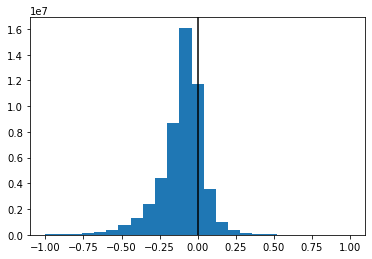

In [503]:
plt.hist(diff_2020_2014, bins=25, range=[-1, 1])
plt.axvline(0, color='k')

### NCALM 2022
The NCALM data uses snow-on field data extracted at points for vertical bias correction. <br>

Create json for each individual file

In [ ]:
# name JSON file
extract_las_atPoint_json = json_base_path +'extract_las_atPoint.json'

# def extract_las_atPoint(filenames, tags, target_point, output_txt):
    
#     # merge all las files or stages
#     filter_merge = {"type":"filters.merge",
#                     "tag": "merged",
#                     "inputs": tags}
#     # crop
#     filter_crop = {'type':'filters.crop',
#                    'point':target_point,
#                    'distance':3,
#                    'inputs':'merged',
#                    'tag': 'cropped'}
#     # crop
#     filter_range = {'type':'filters.range',
#                    'limits':'Classification[2:2]',
#                    'inputs':'cropped',
#                    'tag': 'range'}
    
#     # write merged las to raster
#     writers_gdal = {"type":"writers.text",
#                     "format":"csv",
#                     "order":"Z",
#                     "write_header":False,
#                     'keep_unspecified':False,
#                     'filename':output_txt}
#     # Append each stage to a list prior to saving to json 
#     pipeline_list = filenames.copy()
#     pipeline_list.append(filter_merge)

#     pipeline_list.append(filter_range)  
#     pipeline_list.append(filter_crop)
#     pipeline_list.append(writers_gdal)

#     pipeline_dict = {'pipeline' : pipeline_list}
#     # save to json
#     with open(extract_las_atPoint_json, 'w') as out:
#         json.dump(pipeline_dict, out, indent=4)
#     pdal_cmd = ['pdal','pipeline', extract_las_atPoint_json]
#     subprocess.run(pdal_cmd)

**Load in Field Data**

In [167]:
# Read in ground_truthed data
def csv_to_list(input_csv):
    src = open(input_csv)
    csvreader = csv.reader(src)
    header = next(csvreader)
    output_list = []
    for row in csvreader:
        output_list.append(row)
    src.close()
    return(header, output_list)

In [168]:
# extract data from field data
field_src = "SCB/supporting_files/combined_field_snow/Piske_2022_snow/SCB_20220323_depth.csv"
field_header, field_data = csv_to_list(field_src)

In [169]:
field_data_df = pd.read_csv(field_src)

In [173]:
field_data_df.Easting[50]

732492

**Create a CSV for Each Field Data Point** <br>
CSV contains all lidar values within a 3m radius of the point

In [7]:
#input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
output_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/vertical_bias_correction/las_vals_target_pts/'
#filenames, tags = lidar_functions.create_command_template(input_path)

In [175]:
# create lists with inputs for function/for loop
output_txt = [0]*len(field_data_df)
target_point = [0]* len(field_data_df)
for i in range(len(field_data_df)):
    output_txt[i] = output_path+'field_data_'+str(field_data_df.Easting[i])+"_"+str(field_data_df.Northing[i])+'.csv'
    target_point[i] = 'POINT('+str(field_data_df.Easting[i])+' '+str(field_data_df.Northing[i])+')'

In [58]:
# time = 4 min
output_txt = [0]*len(field_data)
target_point = [0]* len(field_data)
for i in range(len(field_data)):
    output_txt[i] = output_path+'field_data_'+str(field_data[i][4])+"_"+str(field_data[i][5])+'.csv'
    target_point[i] = 'POINT('+field_data[i][4]+' '+field_data[i][5]+')'

In [11]:
# # this is not working
# # parallel processing
# output_txt = [0]*len(field_data)
# target_point = [0]* len(field_data)
# for i in range(len(field_data)):
#     output_txt[i] = output_path+'field_data_'+str(field_data[i][4])+"_"+str(field_data[i][5])+'.csv'
#     target_point[i] = 'POINT('+field_data[i][4]+' '+field_data[i][5]+')'
    
# if __name__ == '__main__':
#     with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
#         executor.map(lidar_functions_adaptable.extract_las_atPoint, target_point, output_txt)

In [27]:
# this works!
# if we want to parallel process, one option could be to try having the inputs as j (num for target point) and one as output_txt and see if that works... not quite sure why this isn't working
for j in range(len(field_data)):
    extract_las_atPoint_json = json_base_path +'extract_las_atPoint.json'
    # define the input path to the las files
    #******
    input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
    onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))] # make a list of all filenames in directory
    input_list_all = [input_path + s for s in onlyfiles] # make a list of full filename paths in directory
    # now instead of all files, we take only files that contain the target point (here, we use file names that follow
    # the basic file structure that ends with *easing_northing.las
    input_list = input_list_all.copy()
    for files in input_list_all:
        pdal_info_command = ['pdal', 'info', files, '--metadata'] # set up pdal info command
        pdal_info_results = subprocess.run(pdal_info_command, stdout = subprocess.PIPE) # stout (standard out), PIPE indicates that a new pipe to the child should be created, execute command
        pdal_info_dict = json.loads(pdal_info_results.stdout.decode()) # save metadata to dictionary
        minx = int(round(pdal_info_dict['metadata']['minx']))
        maxx = int(round(pdal_info_dict['metadata']['maxx']))
        miny = int(round(pdal_info_dict['metadata']['miny']))
        maxy = int(round(pdal_info_dict['metadata']['maxy']))
        if ((miny <= int(target_point[j][-8:-1]) <= maxy) and (minx <= int(target_point[j][-15:-9]) <=  maxx)) == False:
            input_list.remove(files)

    filename_dict = {} # initiate an empty dict to hold the readers
    tags = ['']*len(input_list) # initiate an empty list, size = number of files
    filenames = ['']*len(input_list) # repeat
    for i in range(len(input_list)): # for each file, create a dictionary element with the values matching json formatting for file merging
        if len(input_list) > 1:
            filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
            tags[i] = 'A_'+str(i) # add a tag to the reader stage
            filenames[i] = filename_dict[list(filename_dict)[i]] # Add all values to a list
        else:
            filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'input_stage'}
            filenames[i] = filename_dict[list(filename_dict)[i]]

    output_txt = output_path+'field_data_'+str(field_data[j][4])+"_"+str(field_data[j][5])+'.csv'
    
    # merge all las files or stages
    filter_merge = {"type":"filters.merge",
                    "tag": "input_stage",
                    "inputs": tags}
    # crop
    filter_crop = {'type':'filters.crop',
                   'point':target_point[j],
                   'distance':3,
                   'inputs':'input_stage',
                   'tag': 'cropped'}

    # range
    filter_range = {'type':'filters.range',
                   'limits':'Classification[2:2]',
                   'inputs':'cropped',
                   'tag': 'range'}            
    # write merged las to raster
    writers_gdal = {"type":"writers.text",
                    "format":"csv",
                    "order":"Z",
                    "write_header":False,
                    'keep_unspecified':False,
                    'filename':output_txt}
    # Append each stage to a list prior to saving to json
    if len(input_list) > 1:
        pipeline_list = filenames.copy()
        pipeline_list.append(filter_merge)
        pipeline_list.append(filter_crop)
        pipeline_list.append(filter_range)  
        pipeline_list.append(writers_gdal)
        pipeline_dict = {'pipeline' : pipeline_list}
    else:
        pipeline_list = filenames.copy()
        pipeline_list.append(filter_crop)
        pipeline_list.append(filter_range)  
        pipeline_list.append(writers_gdal)
        pipeline_dict = {'pipeline' : pipeline_list}
    # save to json
    with open(extract_las_atPoint_json, 'w') as out:
        json.dump(pipeline_dict, out, indent=4)
    pdal_cmd = ['pdal','pipeline', extract_las_atPoint_json]
    subprocess.run(pdal_cmd)

**Load Data**

In [382]:
# load files into a dictionary
NCALM_2022_vbc_dict = {}
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/vertical_bias_correction/las_vals_target_pts/'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
for files in onlyfiles:
    txt_path = input_path + files
    txt_arr = np.loadtxt(txt_path)
    NCALM_2022_vbc_dict[files[:-4]] = txt_arr

In [188]:
int(keys_list[0][-14:-8])

736998

**Calculate Vertical Bias** <br>
Save to dictionary so that we can plot hists and df for ease

In [47]:
NCALM_2022_error_dict = {}
keys_list = list(NCALM_2022_vbc_dict.keys())
for i in range(len(keys_list)):
    easting =  field_data[i][4]
    # add data to field data dataframe
    for j in range(len(keys_list)):
        if easting in keys_list[j]:
            NCALM_2022_error_dict[keys_list[j]] = float(field_data[i][3]) - NCALM_2022_vbc_dict[keys_list[i]]

In [238]:
type(NCALM_2022_vbc_dict[keys_list[0]])

numpy.ndarray

In [251]:
x = float(field_data_df['Depth_m'][field_data_df.Easting == 737013])

In [249]:
field_data_df['Depth_m'][field_data_df.Easting == easting]

3    0.37
Name: Depth_m, dtype: float64

In [451]:
NCALM_2022_error_dict = {}
keys_list = list(NCALM_2022_vbc_dict.keys())
field_data_df['ncalm_mean'] = np.nan
for i in range(len(keys_list)):
    # get the easting value from the filename
    easting =  int(keys_list[i][-14:-8])
    NCALM_2022_error_dict[keys_list[i]] = NCALM_2022_vbc_dict[keys_list[i]] - float(field_data_df['Depth_m'][field_data_df.Easting == easting])
    # add data to field data dataframe
    mask = field_data_df.Easting == easting
    field_data_df.loc[mask, 'ncalm_mean'] = np.mean(NCALM_2022_vbc_dict[keys_list[i]])
    field_data_df.loc[mask, 'ncalm_field_mean'] = np.mean(NCALM_2022_error_dict[keys_list[i]])
    field_data_df.loc[mask, 'ncalm_field_median'] = np.median(NCALM_2022_error_dict[keys_list[i]])
    field_data_df.loc[mask, 'ncalm_field_std'] = np.std(NCALM_2022_error_dict[keys_list[i]])
    field_data_df.loc[mask, 'ncalm_field_low10per'] = np.nanpercentile(NCALM_2022_error_dict[keys_list[i]],10)
    field_data_df.loc[mask, 'ncalm_field_5per'] = np.nanpercentile(NCALM_2022_error_dict[keys_list[i]],5)
    field_data_df.loc[mask, 'ncalm_field_95per'] = np.nanpercentile(NCALM_2022_error_dict[keys_list[i]],95)

In [459]:
med_med = np.nanmedian(field_data_df.ncalm_field_median)
avg_low10per = np.nanmean(field_data_df.ncalm_field_low10per)
avg_mean = np.nanmean(field_data_df.ncalm_field_median)
avg_5per = np.nanmean(field_data_df.ncalm_field_low10per)
avg_95per = np.nanmean(field_data_df.ncalm_field_low10per)


percentile_5th = np.nanpercentile(field_data_df.ncalm_field_median,5)
percentile_95th = np.nanpercentile(field_data_df.ncalm_field_median,95)

print('Median Difference NCALM 2022 - Field Data: ', med_med)
print('Average Difference NCALM 2022 - Field Data: ', avg_mean)
print('5th to 95th Percentile of Corrected distribution: ', round(percentile_5th,3), round(percentile_95th,3))


Median Difference NCALM 2022 - Field Data:  0.04800000000000004
Average Difference NCALM 2022 - Field Data:  0.07772549019607845
5th to 95th Percentile of Corrected distribution:  -0.259 0.508


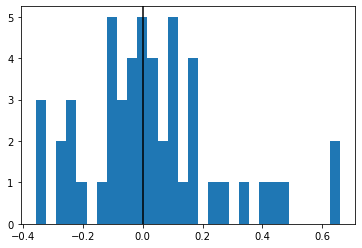

In [460]:
plt.hist(field_data_df.ncalm_field_median-0.048, bins = 30)
plt.axvline(0, color='k')

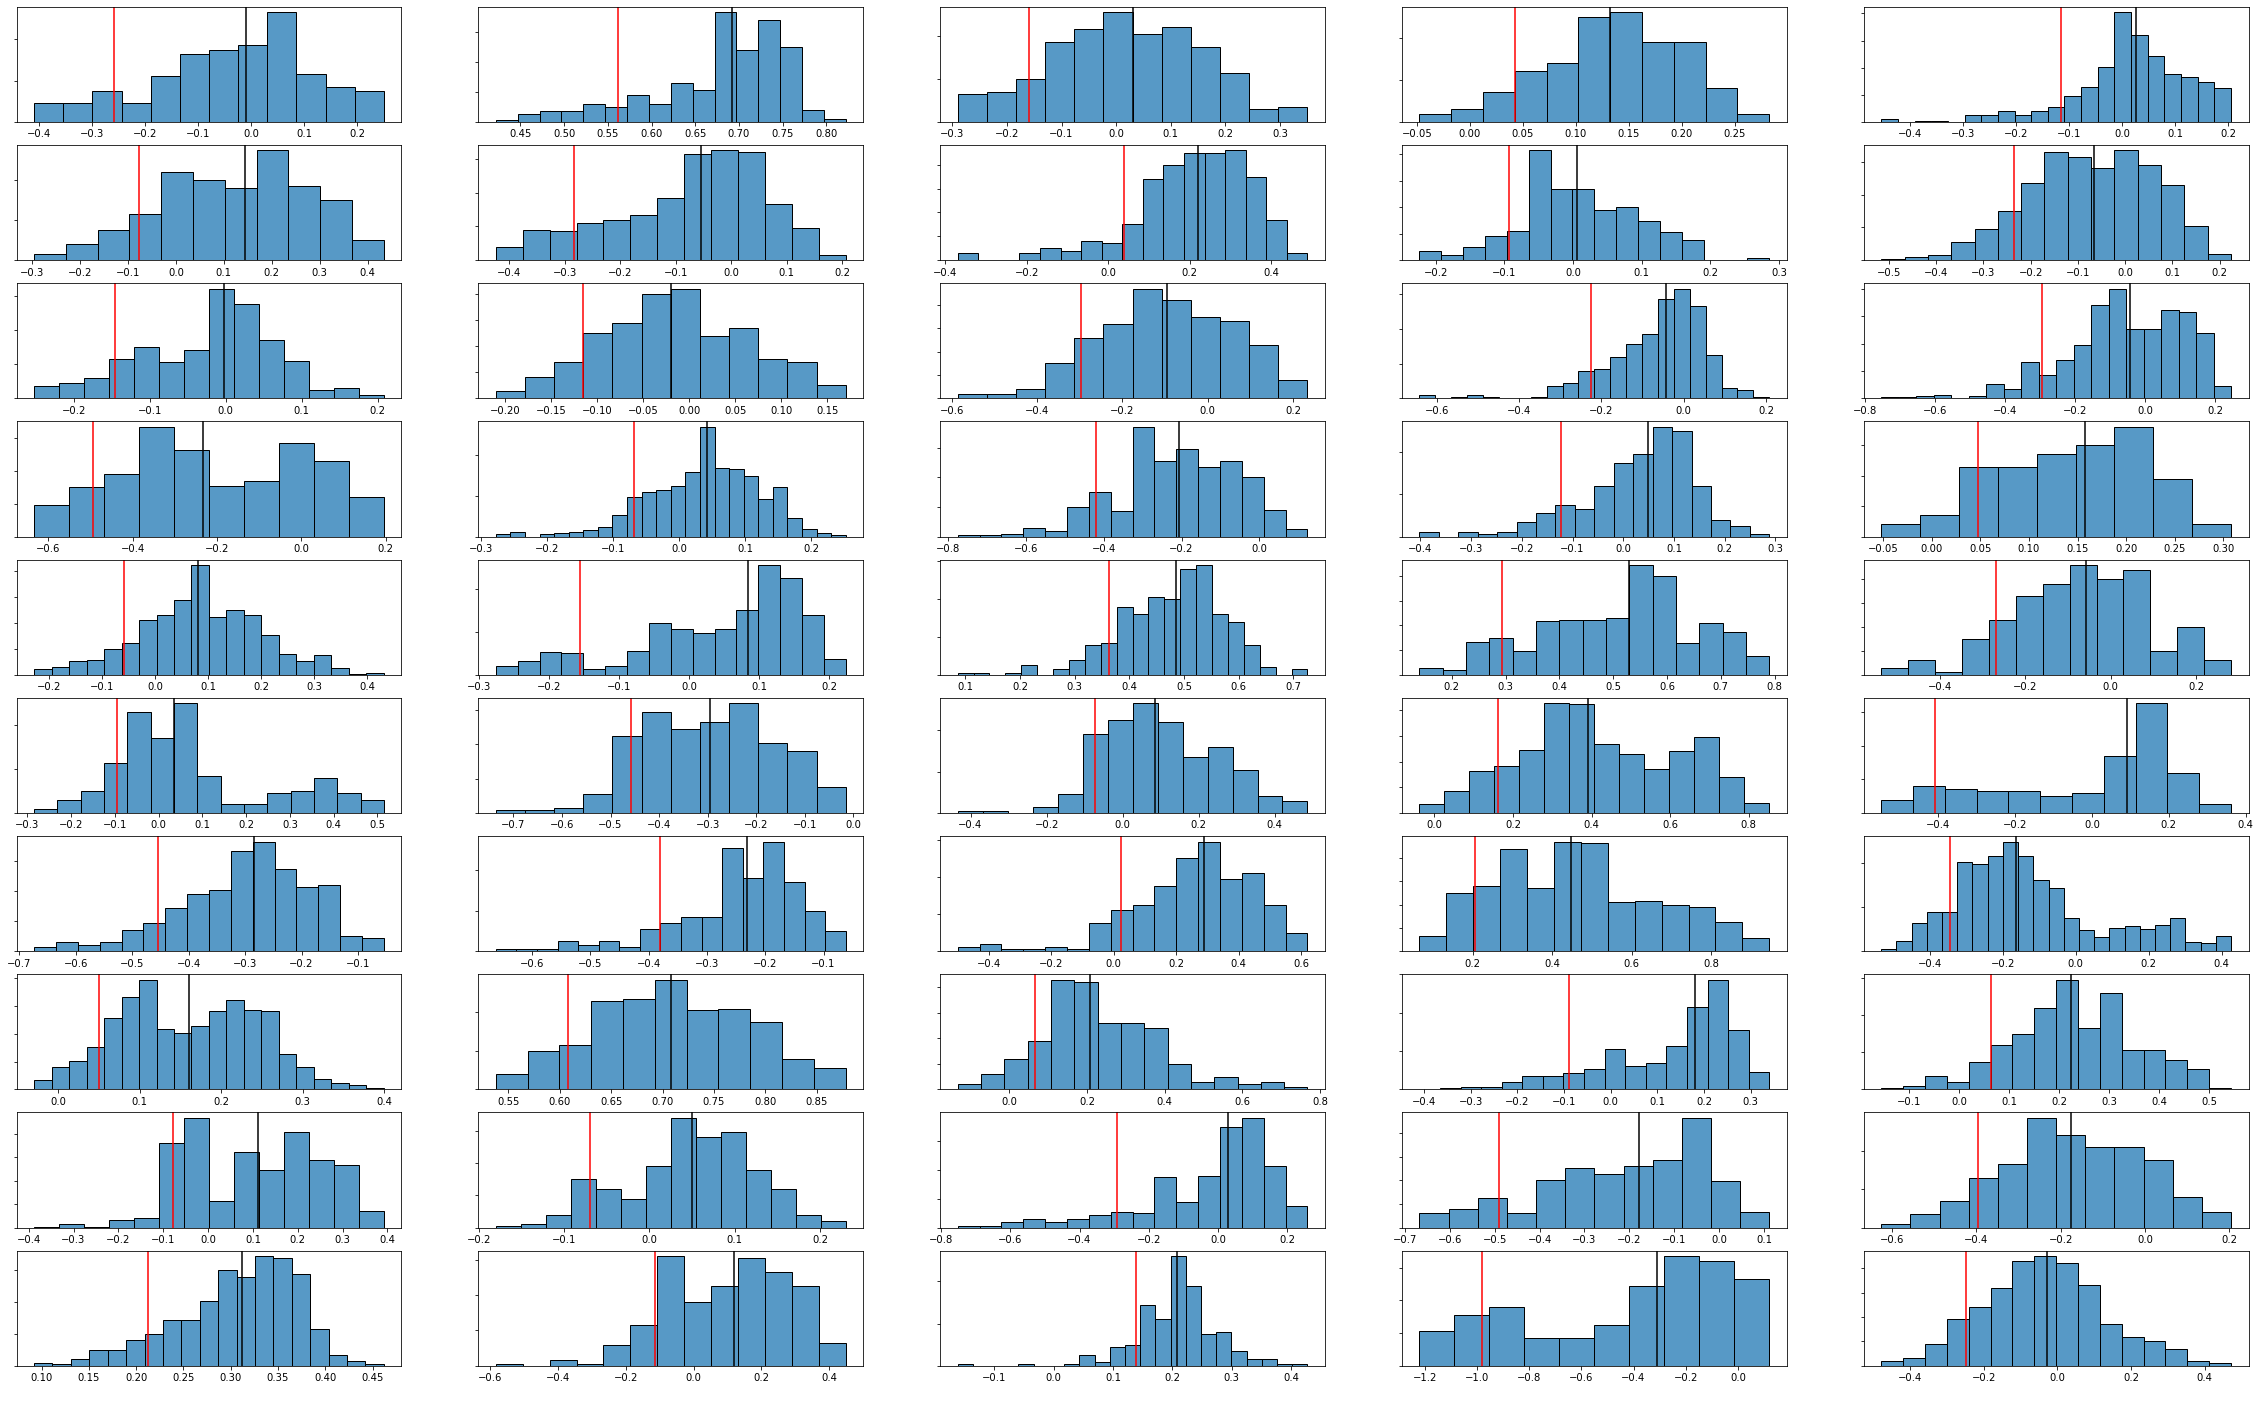

In [386]:
NCALM_2008_error_plot, axs = plt.subplots(10, 5, figsize =(40,25));
#NCALM_2008_error_plot.suptitle('NCALM 2008 Lidar Depth Distributions Around Ground Truth') # add title to entire figure

k = 0
for i in range(5):
    for j in range(10):
        g = sns.histplot(ax = axs[j,i], data = NCALM_2022_error_dict[keys_list[k]])
        easting = int(keys_list[k][-14:-8])
        med = float(field_data_df['ncalm_field_median'][field_data_df.Easting == easting])
        lowest_10 = float(field_data_df['ncalm_field_low10per'][field_data_df.Easting == easting])
        g.axvline(lowest_10, color='red')
        g.axvline(med, color = 'k')
        axs[j,i].set(yticklabels = [], title='', xlabel = ' ',ylabel ='') #str(float(field_data_df['ELEV_M'][field_data_df.Easting == easting]))
        k=k+1

In [385]:
elev_bins_set = ([1900,2000,2100,2200,2300,2400])
field_data_df['elev_bins'] = pd.cut(field_data_df['ELEV_M'], bins=elev_bins_set, right = False,include_lowest= True)

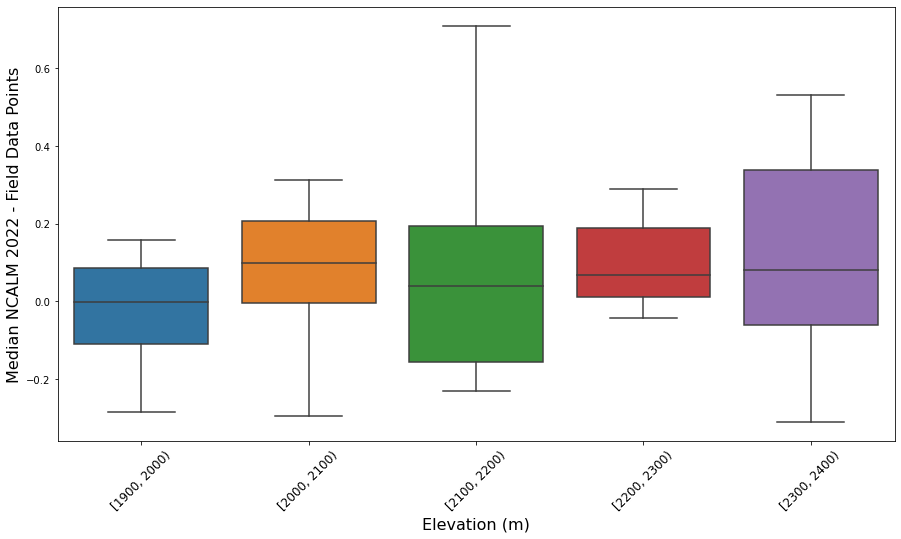

In [334]:
elev_diff_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=field_data_df, x='elev_bins', y="ncalm_field_median",showfliers = False) #, hue = 'nness_bins'
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('Median NCALM 2022 - Field Data Points', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

#elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight')

## Correct and Rasterize
In this case we know that the May flight has the most limited extent. One way to check for this would be to use a similar code to 

Start with snow-on because it's straightforward <br>

1. all vbc values <br>
2. vbc values <=5 <br>
3. vbc values <=3

In [29]:
correct_merge_rasterize_json = json_base_path + 'correct_merge_rasterize.json'

In [30]:
def correct_rasterize(filenames, tags, target_assign, range_limits, writers_bounds, output_tif):

    # merge all las files or stages
    filter_merge = {"type":"filters.merge",
                   "tag": "merged",
                   "inputs": tags}
    # filter out the ground points of the tiles
    filter_assign = {'type': 'filters.assign',
                     'value':"Z="+target_assign,
                     'inputs':'merged',
                     'tag':'corrected'}
    # filter out the ground points of the tiles
    # filter_range = {'type': 'filters.range',
    #                  'limits':"Z[0.15:5]",
    #                  'inputs':'corrected',
    #                  'tag':'ranged'}
    filter_range = {'type': 'filters.range',
                     'limits':range_limits,
                     'inputs':'corrected',
                     'tag':'ranged'}
    # write merged las to raster
    writers_gdal= {"type": "writers.gdal",
                   'output_type': 'mean',
                  'resolution': '1.0',
                  'radius': '0.7',
                   'bounds': writers_bounds,
                   'filename':output_tif}
    # Append each stage to a list prior to saving to json 
    pipeline_list = filenames.copy()
    pipeline_list.append(filter_merge)
    pipeline_list.append(filter_assign)
    pipeline_list.append(filter_range)
    pipeline_list.append(writers_gdal)

    pipeline_dict = {'pipeline' : pipeline_list}
    return(pipeline_dict)


In [466]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', correct_merge_rasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/correct_merge_rasterize.json'], returncode=0)

In [467]:
toc = time.perf_counter()
toc-tic

1418.0822845000075

In [468]:
(toc-tic)/60

23.63470474166679

In [33]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/corrected_tif/NCALM_SCB_20220321_ground_vbc_3.tif'
writers_bounds = '([730235.96, 738826.45], [4364741.66, 4372273.16])'
target_assign = 'Z-0.048'
range_limits ='Classification[2:2], Z[:3]'

In [34]:
pipeline_dict = correct_rasterize(filenames, tags, target_assign, range_limits, writers_bounds, output_tif)
 # save to json
with open(correct_merge_rasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [37]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', correct_merge_rasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/correct_merge_rasterize.json'], returncode=0)

In [38]:
toc = time.perf_counter()

In [42]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/corrected_tif/NCALM_SCB_20220321_ground_vbc_5.tif'
writers_bounds = '([730235.96, 738826.45], [4364741.66, 4372273.16])'
target_assign = 'Z-0.048'
range_limits ='Classification[2:2], Z[:5]'
pipeline_dict = correct_rasterize(filenames, tags, target_assign, range_limits, writers_bounds, output_tif)
 # save to json
with open(correct_merge_rasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [43]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', correct_merge_rasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/correct_merge_rasterize.json'], returncode=0)

In [44]:
toc = time.perf_counter()

In [45]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/corrected_tif/NCALM_SCB_20220321_ground_vbc.tif'
writers_bounds = '([730235.96, 738826.45], [4364741.66, 4372273.16])'
target_assign = 'Z-0.048'
range_limits ='Classification[2:2]'
pipeline_dict = correct_rasterize(filenames, tags, target_assign, range_limits, writers_bounds, output_tif)
 # save to json
with open(correct_merge_rasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [46]:
tic = time.perf_counter()
pdal_cmd = ['pdal','pipeline', correct_merge_rasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/correct_merge_rasterize.json'], returncode=0)

In [47]:
toc = time.perf_counter()

# Snow-Off Processing

In [6]:
writers_bounds

'([730235.96, 738826.45], [4364741.66, 4372273.16])'

In [10]:
# This function allows us to change the json pipeline depending on the files
# the final output of a subprocess that uses this pipeline will be one raster with 1x1m pixels, each containing the number of returns (counts) of the specified lidar height strata
# e.g. if the range_limit is Z[-0.15:0.15), each pixel will give us the number of returns between -0.15 and 0.15 in elevation (HAG in this case)
# The goal of this function is to return a json pipeline with specific Z limits
# input: filenames - see: lidar_functions.create_command_template
# input: target_assign - if you need to perform a vertical bias correction on the snow-off flight, insert a string with the correction function (e.g. 'Z+0.05' if you need to add 0.05 to each lidar point), if no correction is necessary
# insert "Z+0" [str]
# input: writers_bounds - '([minx, maxx], [miny, maxy])';  e.g.'([730235.96, 738826.45], [4364741.66, 4372273.16])' [str]
# input: range_limits: Z limits for output file
def create_vegetation_heigh_strata(filenames, tags, target_assign, writers_bounds, range_limits, output_tif): 
    # merge all las files or stages
    filter_merge = {"type":"filters.merge",
                   "tag": "merged",
                   "inputs": tags}
    # bias correct files
    filter_assign = {'type': 'filters.assign',
                     'value':"Z="+target_assign,
                     'inputs':'merged',
                     'tag':'corrected'}
    # filter out the ground points of the tiles
    filter_range = {"type":"filters.range",
                    "limits":range_limits,
                   'inputs':'corrected',
                   'tag':'filtered'}
    # write merged las to raster
    writers_gdal= {"type": "writers.gdal",
                   'output_type': 'count',
                  'resolution': '1.0',
                  'radius': '0.7',
                   'bounds': writers_bounds,
                   'filename':output_tif}
    # Append each stage to a list prior to saving to json 
    pipeline_list = filenames.copy()
    pipeline_list.append(filter_merge)
    pipeline_list.append(filter_assign)
    pipeline_list.append(filter_range)
    pipeline_list.append(writers_gdal)

    pipeline_dict = {'pipeline' : pipeline_list}
    return(pipeline_dict)

### Vegetation Strata

**Combined Pipeline Method**
Vegetation Height Strata:<br>
[-0.15:0.15), used to determine open sites<br>
[0.15:1.5), if there are returns in this region, we can look into weather there is short vegetation or understory here<br>
[1.5:3), we remove all pixels with returns here, classified as "low branches or significant shrub/grass/ground-veg"<br>
[3:), this is our threshold for "tall" vegetation<br>

Constant inputs

In [24]:
# this remains the same for all heigh strata
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
target_assign = "Z+0.08"

Variable inputs

[-0.15:0.15)

In [14]:
# specify name of the json pipeline file
filterMergeRasterize_json = json_base_path+'filterMergeRasterize_neg0pt15_0pt15.json'
# specify output tif file path
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_height_strata/vegStrata_neg0pt15_0pt1.tif'
# heigh strata range limits
range_limits = 'Z[-0.15:0.15)'
# create pipline
pipeline_dict = create_vegetation_heigh_strata(filenames, tags, target_assign, writers_bounds, range_limits, output_tif)
# save to json
with open(filterMergeRasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


In [16]:
tic = time.perf_counter()

In [17]:
pdal_cmd = ['pdal','pipeline', filterMergeRasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/filterMergeRasterize_neg0pt15_0pt15.json'], returncode=0)

In [18]:
toc = time.perf_counter()

In [19]:
(toc-tic)/60

16.56809745

[0.15:1.5)

In [14]:
# specify name of the json pipeline file
filterMergeRasterize_json = json_base_path+'filterMergeRasterize_0pt15_1pt5.json'
# specify output tif file path
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_height_strata/vegStrata_0pt15_1pt5.tif'
# heigh strata range limits
range_limits = 'Z[0.15:1.5)'
# create pipline
pipeline_dict = create_vegetation_heigh_strata(filenames, tags, target_assign, writers_bounds, range_limits, output_tif)
# save to json
with open(filterMergeRasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)
pdal_cmd = ['pdal','pipeline', filterMergeRasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/filterMergeRasterize_0pt15_1pt5.json'], returncode=0)

[1.5:3)

In [25]:
# specify name of the json pipeline file
filterMergeRasterize_json = json_base_path+'filterMergeRasterize_1pt5_3.json'
# specify output tif file path
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_height_strata/vegStrata_1pt5_3.tif'
# heigh strata range limits
range_limits = 'Z[1.5:3)'
# create pipline
pipeline_dict = create_vegetation_heigh_strata(filenames, tags, target_assign, writers_bounds, range_limits, output_tif)
# save to json
with open(filterMergeRasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)
pdal_cmd = ['pdal','pipeline', filterMergeRasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/filterMergeRasterize_1pt5_3.json'], returncode=0)

[3:)

In [27]:
# specify name of the json pipeline file
# this remains the same for all heigh strata
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/HAG/'
filenames, tags = lidar_functions.create_command_template(input_path)
target_assign = "Z+0.08"

filterMergeRasterize_json = json_base_path+'filterMergeRasterize_3.json'
# specify output tif file path
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_height_strata/vegStrata_3.tif'
# heigh strata range limits
range_limits = 'Z[3:)'
# create pipline
pipeline_dict = create_vegetation_heigh_strata(filenames, tags, target_assign, writers_bounds, range_limits, output_tif)
# save to json
with open(filterMergeRasterize_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)
pdal_cmd = ['pdal','pipeline', filterMergeRasterize_json]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/filterMergeRasterize_3.json'], returncode=0)

### Create CHM

Note that there are two CHMs for these data. One is based off all points, another is limited to possible short/understory vegetation (<1.5m)

In [49]:
CHM_json = json_base_path+'CHM_from_las.json' # define path to json files
CHM_json_LT1pt5 = json_base_path+'CHM_from_las_LT1pt5.json' # define path to json files

In [50]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/HAG/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/CHM/NCALM_SCB_2020_CHM_LT1pt5.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]
target_assign = "Z+0.081"

In [51]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [52]:
writers_bounds

'([730235.96, 738826.45], [4364741.66, 4372273.16])'

In [53]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
filter_assign = {'type': 'filters.assign',
                'value':"Z="+target_assign,
                'inputs':'merged',
                'tag':'corrected'}
filter_range = {'type': 'filters.range',
                'limits': 'Z[-0.15:1.5]',
                'inputs':'corrected',
                'tag':'ranged'}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'max', 
              'resolution': '1.0',
               'bounds': writers_bounds,
              'radius': '0.7',
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_assign)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
# with open(CHM_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)
with open(CHM_json_LT1pt5, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [54]:
tic = time.perf_counter()

In [55]:
pdal_cmd = ['pdal','pipeline', CHM_json_LT1pt5]
subprocess.run(pdal_cmd)

CompletedProcess(args=['pdal', 'pipeline', 'piske_processing/PDAL_workflow/JSON/CHM_from_las_LT1pt5.json'], returncode=0)

In [56]:
toc = time.perf_counter()

In [57]:
(toc-tic)/60

17.891041734999938

In [20]:
CHM_json = json_base_path+'CHM_from_las.json' # define path to json files


In [21]:
input_path = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/HAG/'
output_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/CHM/NCALM_SCB_2020_CHM.tif'
onlyfiles = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]
input_list = [input_path + s for s in onlyfiles]
target_assign = "Z+0.081"

In [22]:
filename_dict = {}
tags = ['']*len(input_list)
filenames = ['']*len(input_list)
for i in range(len(input_list)):
    filename_dict['filename_'+str(i)] = {'filename':input_list[i], 'tag':'A_'+str(i)}
    tags[i] = 'A_'+str(i)
    filenames[i] = filename_dict[list(filename_dict)[i]]

In [16]:
writers_bounds

'([730235.96, 738826.45], [4364741.66, 4372273.16])'

In [23]:
# merge all las files or stages
filter_merge = {"type":"filters.merge",
               "tag": "merged",
               "inputs": tags}
filter_assign = {'type': 'filters.assign',
                'value':"Z="+target_assign,
                'inputs':'merged',
                'tag':'corrected'}
filter_range = {'type': 'filters.range',
                'limits': 'Z[-0.15:70]',
                'inputs':'corrected',
                'tag':'ranged'}
# write merged las to raster
writers_gdal= {"type": "writers.gdal",
               'output_type': 'max', 
              'resolution': '1.0',
               'bounds': writers_bounds,
              'radius': '0.7',
               'filename': output_tif}
# Append each stage to a list prior to saving to json 
pipeline_list = filenames.copy()
pipeline_list.append(filter_merge)
pipeline_list.append(filter_assign)
pipeline_list.append(filter_range)
pipeline_list.append(writers_gdal)
pipeline_dict = {'pipeline' : pipeline_list}
# save to json
# with open(CHM_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)
with open(CHM_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)

In [18]:
tic = time.perf_counter()

In [ ]:
pdal_cmd = ['pdal','pipeline', CHM_json]
subprocess.run(pdal_cmd)

In [20]:
toc = time.perf_counter()

In [21]:
(toc-tic)/60

21.333165216666657

# Assign projections
Outputs are automatically assigned a CRS EPSG 26910 but they should be 6339... Very minor but best practice to keep consistent

**Move to Raster workflow**

# ------------------------------

# Extras

## File format conversions

### Convert .las to .txt
see: https://pdal.io/stages/writers.text.html

In [ ]:
# set up json file commands
output_txt = '/Volumes/cpiske/lidar_processing/python_scripts/PDAL/test_las/mcc_part_b_tile_004_000Test.asc'
output_json = 'lidar_processing/python_scripts/PDAL_workflow/JSON/las_to_txt.json'

# create a pipeline and save to a json file 

filter_dict = {'type':'readers.las',
               'override_srs': "EPSG:4326",
              'filename': input_las} # we are reading in a las file
rasterize_dict = {'type':'writers.las',
'format':'geojson',
'order':'X,Y,Z',
'keep_unspecified':'false',
'filename':output_txt}


pipeline_list = [filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


In [ ]:
json_path = 'lidar_processing/python_scripts/PDAL/JSON/las_to_txt.json'
pdal_commands = ['pdal', 'pipeline', json_path]
subprocess.run(pdal_commands)

### .laz to .las

In [ ]:
# # set up json file commands
# input_laz = 'lidar_processing/python_scripts/PDAL/test_las/ASO_USCAMB20180425f1a1_180425_1_dem_filter.laz'
# output_las = 'lidar_processing/python_scripts/PDAL/test_las/ASO_USCAMB20180425f1a1_180425_1_dem_filter.las'
# output_json = 'lidar_processing/python_scripts/PDAL/JSON/laz_to_las.json'

# # create a pipeline and save to a json file 

# filter_dict = {'type':'readers.las',
#                'filename': input_las} # we are reading in a las file
# translate_dict = {'type':'writers.las',
#                   "a_srs": "EPSG:4326",
#                   'filename':output_las}


# pipeline_list = [filter_dict, translate_dict]
# pipeline_dict = {'pipeline' : pipeline_list}
# with open(output_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)


In [ ]:
# json_path = 'lidar_processing/python_scripts/PDAL/JSON/laz_to_las.json'
# pdal_commands = ['pdal', 'pipeline', json_path]
# subprocess.run(pdal_commands)

# Raster Caluclations

In [ ]:
for i in [0,1,2,3,4,5]:
    apr_elev = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/rasterize/ASO_20160417/mcc_part_b_tile_004_00'+str(i)+'.tif'
    may_elev = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/rasterize/ASO_20160518/mcc_part_b_tile_004_00'+str(i)+'.tif'
    output = 'lidar_processing/PDAL_testFiles_tutorials/test_las/SCB/raster_subtract/mcc_part_b_tile_004_00'+str(i)+'.tif'
    raster_sub = ['gdal_calc.py', '-a', apr_elev, '-b', may_elev, '--calc="a - b"', '--outfile', output]
    subprocess.run(raster_sub)

# Theo Code

In [ ]:
input_las = 'SCB/kost_lidar_data/ASO_2016/2016_05_18/WGS84_G1762_to_NAD83_NAVD88/mcc_part_b_tile_004_000.las'

z_min = 0.15
z_max = 2
z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
output_raster = 'lidar_processing/python_scripts/PDAL/test_file/mcc_part_b_tile_004_000.tif'
output_json = 'lidar_processing/python_scripts/PDAL/JSON/las_to_tif.json'
resolution = 0.01

filter_dict = {'type':'filters.range', 'limits':z_range}
rasterize_dict = {'filename':output_raster,
'gdaldriver':'GTiff',
'output_type':'count',
'resolution':resolution,
'type': 'writers.gdal'}


pipeline_list = [input_las, filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


In [ ]:
input_las = 'SCB/kost_lidar_data/ASO_2016/2016_05_18/WGS84_G1762_to_NAD83_NAVD88/mcc_part_b_tile_004_000.las'

# z_min = 0.15
# z_max = 2
# z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
output_raster = 'lidar_processing/python_scripts/PDAL/test_file/mcc_part_b_tile_004_000.asc'
output_json = 'lidar_processing/python_scripts/PDAL/JSON/las_to_asc.json'
resolution = 0.01

filter_dict = {'type':'filters.range', 'limits':z_range}
rasterize_dict = {'filename':output_raster,
'gdaldriver':'XYZ',
'output_type':'count',
'resolution':resolution,
'type': 'writers.gdal'}


pipeline_list = [input_las, filter_dict, rasterize_dict]
pipeline_dict = {'pipeline' : pipeline_list}
with open(output_json, 'w') as out:
    json.dump(pipeline_dict, out, indent=4)


sudo docker run -v path_to_laz_folder:/input 0b pdal info /input/test.laz

where path_to_laz_folder is the path to the LAS/LAZ file (you just need the folder path, not the file path).

:/input is the new folder that will be created in your Docker container that will hold your point cloud.

0b is just the image id of pdal

/input/test.laz is the path to the point cloud in the Docker container.


In [ ]:
path_to_laz_folder = 'lidar_processing/python_scripts/PDAL/test_las'


In [ ]:
sudo docker run -v path_to_laz_folder:/input 0b pdal info /input/test.laz


In [ ]:
import json
import subprocess
import pdal

def assemblePipeline(input_las, list_of_dicts):
    pipeline_list = [input_las]
    pipeline_list.extend(list_of_dicts)
    pipeline_dict = {'pipeline' : pipeline_list}
    return pipeline_dict

def makeHeightFilter(height, buffer):
    z_min = height - buffer/2
    z_max = height + buffer/2
    z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
    heightDict = {'type':'filters.range', 'limits':z_range}
    return heightDict

def makeRasterizeFilter(output_raster, resolution, epsg):
    rasterize_dict = {'filename':output_raster,
                      'gdaldriver':'GTiff',
                      'output_type':'count',
                      'resolution':resolution,
                      'override_srs' : epsg,
                      'type': 'writers.gdal'}
    return rasterize_dict

def convertTifForPIL(input_raster, output_raster, epsg):
    ''' GDAL bindings are an alien concept to me, so I gave up and used
        subprocess.'''
    commands = ['gdal_translate', input_raster, output_raster, '-ot', 'Byte', '-a_srs', epsg]
    subprocess.run(commands)


def buildHeightSlice(input_las, height, buffer, output_raster, resolution, epsg, json_path=None):
    filter_dict = makeHeightFilter(height, buffer)
    rasterize_dict = makeRasterizeFilter(output_raster, resolution, epsg)
    filter_list = [filter_dict, rasterize_dict]
    pipeline_dict = assemblePipeline(input_las, filter_list)

    if json_path is not None:
        with open(json_path, 'w') as out:
            json.dump(pipeline_dict, out, indent=4)
        pdal_commands = ['pdal', 'pipeline', json_path]
        subprocess.run(pdal_commands)
    else:
        pdal_commands = json.dumps(pipeline_dict)
        pipeline = pdal.Pipeline(pdal_commands)
        pipeline.execute()

input_las = '/Users/theo/data/las/TLS_0244_20180612_01_v003_30m_clip_height_norm.las'
height = 1.37
buffer = 0.05
z_min = height - buffer/2
z_max = height + buffer/2
z_range = 'Z[' + str(z_min) + ':' + str(z_max) + ']'
temp_raster = '/Users/theo/Pictures/almost_cool.tif'
final_raster = '/Users/theo/Pictures/cool.tif'
resolution = 0.01
epsg = 'EPSG:3310'

buildHeightSlice(input_las, height, buffer, temp_raster, resolution, epsg)
convertTifForPIL(temp_raster, final_raster, epsg)

In [ ]:
import json
import subprocess
import pdal
import argparse

# Create flags for the user to utilize.
parser = argparse.ArgumentParser(description="Generate JSON pipeline to generate DTM from a point cloud.")
      
required = parser.add_argument_group('Required arguments')
required.add_argument('-crs', '--coordinate_system', required=True, action='store', help="EPSG code.")
required.add_argument('-i', '--infile', required=True, action='store', help="Input path to point cloud")
required.add_argument('-o', '--outfile', required=True, action='store', help="Output path.")
args = parser.parse_args()

def generateJSON(infile, list_of_dicts):
    pipeline_list = [infile]
    pipeline_list.extend(list_of_dicts)
    pipeline_dict = {'pipeline': pipeline_list}
    with open("pipeline.json", 'w') as out:
        json.dump(pipeline_dict, out, indent=4)

def generateDTM(epsg, infile, outfile):
    reproject_dict = {"type": "filters.reprojection",
                      "out_srs": "EPSG:{}".format(epsg)}
    reclassify_zero_dict = {"type": "filters.assign",
                       "assignment": "Classification[:]=0"}
    elm_dict = {"type": "filters.elm"}
    outlier_dict = {"type": "filters.outlier"}
    smrf_dict = {"type": "filters.smrf", "ignore": "Classification[7:7]",
                 "slope": 0.2, "window": 16, "threshold": 0.45, "scalar": 1.2}
    range_dict = {"type":"filters.range", "limits":"Classification[2:2]"}
    output_dict = {"filename": outfile, "gdaldriver": "GTiff", "output_type": "all", "resolution": 0.01, "type": "writers.gdal"}
    list_of_dicts = list([reproject_dict, reclassify_zero_dict, elm_dict, outlier_dict, smrf_dict, range_dict, output_dict])
    generateJSON(infile, list_of_dicts)
    pdal_cmds = ['pdal', 'pipeline', 'pipeline.json']
    subprocess.run(pdal_cmds)
    
generateDTM(args.coordinate_system, args.infile, args.outfile)

# More helpful things

### Get stats of a dataset
see: https://www.spatialised.net/lidar-qa-with-pdal-part-1/

In [ ]:
# name JSON file

stats_json = 'lidar_processing/python_scripts/PDAL_workflow/JSON/stats.json'

In [ ]:
reader_las = {"type":"readers.las",
              "filename": input_las_stats}
filter_stats = {"type":"filters.stats",
                "dimensions":"Z",
                "global":"Z",
                "advanced":"true"}
pipeline_list = [reader_las, filter_stats]
#pipeline_dict = {reader_las, filter_stats}
# with open(stats_json, 'w') as out:
#     json.dump(pipeline_dict, out, indent=4)


In [ ]:
pipeline_list

In [ ]:
pipeline = pdal.Pipeline(json.dumps(pipeline_list))
pipeline.execute()

In [ ]:
json.loads(pipeline.metadata)["metadata"]["filters.stats"]["statistic"]

## Navigating folders/files

**create list of files/folders with a wildcard (*)**

In [ ]:
# ex. list all files in folder4 that end in .laz = folder1/folder2/folder3/folder4/*.laz
# ex. list all folders named folder3 in folder 1 = foler1/*/folder3
# ex. list all list all contents in folder2 = folder2/* - note just folder 2, no subdirectories
glob_cmd = 'path'
glob_exe = glob.glob(file_glob_cmd)

**create a list with all directories/subdirectories on a path**

In [ ]:
all_folders = [x[0] for x in os.walk('path')]

**create a list with all directories/subdirectories on a path with specific folders**

In [ ]:
all_folders = [x[0] for x in os.walk('path')]
index_pos_list = [ i for i in range(len(all_folders)) if all_folders[i][-6:] == 'retile' ] # must change this to meet requirements
full_list = [all_folders[i] for i in index_pos_list]

**get name of the directory just above one listed**

In [ ]:
subdirname = os.path.basename(os.path.dirname('path'))

**create a list with only filenames**

In [ ]:
onlyfiles = [f for f in os.listdir('path') if os.path.isfile(os.path.join('path', f))]

**create a list with full file paths**

In [ ]:
full_path = ['path' + '/' + s for s in onlyfiles]

## Parallel Processing

In [ ]:
# time = 142.5
tic = time.perf_counter()
list(map(function, args));
toc = time.perf_counter()

In [ ]:
# time = 53 s
tic = time.perf_counter()
if __name__ == "__main__":
    pool = Pool(3)
    pool.map(function, arg)
    pool.close()
toc = time.perf_counter()

In [ ]:
# time = very fast? .06s
tic = time.perf_counter()
if __name__ == "__main__":
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=3)
    executor.map(function, arg)
toc = time.perf_counter()

In [ ]:
# time = 0.22
tic = time.perf_counter()
if __name__ == "__main__":
    executor = concurrent.futures.ProcessPoolExecutor(max_workers=3)
    executor.map(function, arg)
toc = time.perf_counter()